In [1]:
import os
import torch
import pwcca
import timeit
import random
import librosa
import opensmile
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import soundfile as sf
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import CCA
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, normalize
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from sklearn.metrics import classification_report, confusion_matrix

In [52]:
import sys
sys.path.append('/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/phdwork/Layerwise')

In [3]:
path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

durs = []
lens = []

for file in os.listdir('.'):
    dur = librosa.get_duration(filename=file)
    audioinput, sr = librosa.load(file, sr=16000)
    durs.append(dur)
    lens.append(len(audioinput))

print(max(durs), max(lens))

print(np.mean(np.array(durs)) + np.std(np.array(durs))) # ave duration + std deviation
print(np.mean(np.array(lens)) + np.std(np.array(lens))) # ave duration + std deviation

8.97825 143652
3.806839123563467
60909.42597701548


In [3]:
path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

hct_A = np.array([])
hct_E = np.array([])
hct_F = np.array([])
hct_L = np.array([])
hct_N = np.array([])
hct_T = np.array([])
hct_W = np.array([])

for file in os.listdir('.'):
    audioinput, sr = librosa.load(file, sr=16000)
    audioinput = librosa.util.fix_length(audioinput, size=143652, mode="edge") #pad to same length
    
#     utterance features
#     utter = []
#     kur = kurtosis(audioinput)
#     ske = skew(audioinput)
#     ma = np.amax(np.array(audioinput), axis=0)
#     mi = np.amin(np.array(audioinput), axis=0)
#     ave = np.mean(np.array(audioinput), axis=0)
#     var = np.var(np.array(audioinput), axis=0)
    
#     for i in (kur, ske, ma, mi, ave, var):
#         utter.append(i)
    
#     spectral features
    mfcc = librosa.feature.mfcc(y=audioinput, sr=sr, n_fft=800, hop_length=400, n_mfcc=40)
    mfcc_frame = np.mean(mfcc.T, axis=0) #frame level
#     mfcc_phoneme = []
#     for i in range(0,len(mfcc_frame)-3,2):
#         mfcc_phoneme.append((mfcc_frame[i]+mfcc_frame[i+1]+mfcc_frame[i+2])/3) #phoneme level
#     mfcc_word=[]
#     for i in range(0, len(mfcc_phoneme)-5,4):
#         mfcc_word.append((mfcc_phoneme[i]+mfcc_phoneme[i+1]+mfcc_phoneme[i+4])/5) #word level
#     mfcc_utter=[]
#     mfcc_utter = np.mean(mfcc_word) #utterance level

#     for i in (kur, ske, ma, mi, ave, var):
#         mfcc_utter = np.append(mfcc_utter, i)

#     mel = librosa.feature.melspectrogram(y=audioinput, sr=sr, n_fft=800, hop_length=400)
#     mel_del = librosa.feature.delta(mel, order=1)
#     mel_del2 = librosa.feature.delta(mel, order=2)
#     mels = np.vstack((mel, mel_del, mel_del2))
#     mels_frame = np.mean(mels.T, axis=0)
#     mels_phoneme = []
#     for i in range(0,len(mels_frame)-3,2):
#         mels_phoneme.append((mels_frame[i]+mels_frame[i+1]+mels_frame[i+2])/3) #phoneme level
#     mels_word=[]
#     for i in range(0, len(mels_phoneme)-5,4):
#         mels_word.append((mels_phoneme[i]+mels_phoneme[i+1]+mels_phoneme[i+4])/5) #word level
#     mels_utter=[]
#     for i in range(0, len(mels_word)-10,9):
#         mels_utter.append((mels_word[i]+mels_word[i+1]+mels_word[i+9])/5) #utterance level
            
#     prosodic features
#     eng_frame = librosa.feature.rms(y=audioinput, frame_length=800, hop_length=400)
#     f0_frame = librosa.yin(audioinput, frame_length=800, hop_length=400, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

#     eng_phoneme = []
#     for i in range(0,len(eng_frame)-3,2):
#         eng_phoneme.append((eng_frame[i]+eng_frame[i+1]+eng_frame[i+2])/3) #phoneme level
#     eng_word=[]
#     for i in range(0, len(eng_phoneme)-5,4):
#         eng_word.append((eng_phoneme[i]+eng_phoneme[i+1]+eng_phoneme[i+4])/5) #word level
#     eng_utter=[]
#     for i in range(0, len(eng_word)-10,9):
#         eng_utter.append((eng_word[i]+eng_word[i+1]+eng_word[i+9])/5) #utterance level
        
#     f0_phoneme = []
#     for i in range(0,len(f0_frame)-3,2):
#         f0_phoneme.append((f0_frame[i]+f0_frame[i+1]+f0_frame[i+2])/3) #phoneme level
#     f0_word=[]
#     for i in range(0, len(f0_phoneme)-5,4):
#         f0_word.append((f0_phoneme[i]+f0_phoneme[i+1]+f0_phoneme[i+4])/5) #word level
#     f0_utter=[]
#     for i in range(0, len(f0_word)-10,9):
#         f0_utter.append((f0_word[i]+f0_word[i+1]+f0_word[i+9])/5) #utterance level
    
#     kur_e = kurtosis(eng_frame)
#     ske_e = skew(eng_frame)
#     max_e = np.amax(np.array(eng_frame), axis=0)
#     min_e = np.amin(np.array(eng_frame), axis=0)
#     ave_e = np.mean(np.array(eng_frame), axis=0)
#     rag_e = max_e-min_e
    
#     kur_f = kurtosis(f0_frame)
#     ske_f = skew(f0_frame)
#     max_f = np.amax(np.array(f0_frame), axis=0)
#     min_f = np.amin(np.array(f0_frame), axis=0)
#     ave_f = np.mean(np.array(f0_frame), axis=0)
#     rag_f = max_f-min_f

#     for i in (kur_e, ske_e, max_e, min_e, ave_e, rag_e):
#         eng_utter.append(i)
#     for i in (kur_f, ske_f, max_f, min_f, ave_f, rag_f):
#         f0_utter.append(i)
    
    hct = np.array(mfcc_frame)
    
    #separate accroindg to emotions
    if file[5] == 'A':
        hct_A = np.append(hct_A, hct)
        hct_A = np.reshape(hct_A, (-1, hct.size))
    elif file[5] == 'E':
        hct_E = np.append(hct_E, hct)
        hct_E = np.reshape(hct_E, (-1, hct.size)) 
    elif file[5] == 'F':
        hct_F = np.append(hct_F, hct)
        hct_F = np.reshape(hct_F, (-1, hct.size))
    elif file[5] == 'L':
        hct_L = np.append(hct_L, hct)
        hct_L = np.reshape(hct_L, (-1, hct.size))
    elif file[5] == 'N':
        hct_N = np.append(hct_N, hct)
        hct_N = np.reshape(hct_N, (-1, hct.size))
    elif file[5] == 'T':
        hct_T = np.append(hct_T, hct)
        hct_T = np.reshape(hct_T, (-1, hct.size))
    elif file[5] == 'W':
        hct_W = np.append(hct_W, hct)
        hct_W = np.reshape(hct_W, (-1, hct.size))

print('finished')

finished


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
w2v_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53-german").to(device)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-xlsr-53-german")

In [3]:
labels = [0] * 69 + [1] * 46 + [2] * 71 + [3] * 81 + [4] * 79 + [5] * 62 + [6] * 127

In [6]:
path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

hct_A = np.array([])
hct_E = np.array([])
hct_F = np.array([])
hct_L = np.array([])
hct_N = np.array([])
hct_T = np.array([])
hct_W = np.array([])

torch.cuda.empty_cache()

for file in os.listdir('.'):
    audioinput, sr = librosa.load(file, sr=16000)
    audioinput = librosa.util.fix_length(audioinput, size=143652, mode="edge") #pad to same length    
    
    #w2v features
    input_values = processor(audioinput, sampling_rate=16000, return_tensors="pt").input_values.to(device)
    w2v_feats = w2v_model(input_values, output_hidden_states=True).hidden_states
    w2v_feats_layer = w2v_feats[0].detach()[0].mean(dim=0)
        
    hct = np.array(w2v_feats_layer.cpu())
    torch.cuda.empty_cache()
    
    #separate accroindg to emotions
    if file[5] == 'A':
        hct_A = np.append(hct_A, hct)
        hct_A = np.reshape(hct_A, (-1, hct.size))
    elif file[5] == 'E':
        hct_E = np.append(hct_E, hct)
        hct_E = np.reshape(hct_E, (-1, hct.size)) 
    elif file[5] == 'F':
        hct_F = np.append(hct_F, hct)
        hct_F = np.reshape(hct_F, (-1, hct.size))
    elif file[5] == 'L':
        hct_L = np.append(hct_L, hct)
        hct_L = np.reshape(hct_L, (-1, hct.size))
    elif file[5] == 'N':
        hct_N = np.append(hct_N, hct)
        hct_N = np.reshape(hct_N, (-1, hct.size))
    elif file[5] == 'T':
        hct_T = np.append(hct_T, hct)
        hct_T = np.reshape(hct_T, (-1, hct.size))
    elif file[5] == 'W':
        hct_W = np.append(hct_W, hct)
        hct_W = np.reshape(hct_W, (-1, hct.size))
        
hct_feats = np.vstack((hct_A, hct_E, hct_F, hct_L, hct_N, hct_T, hct_W))
print('finished')

finished


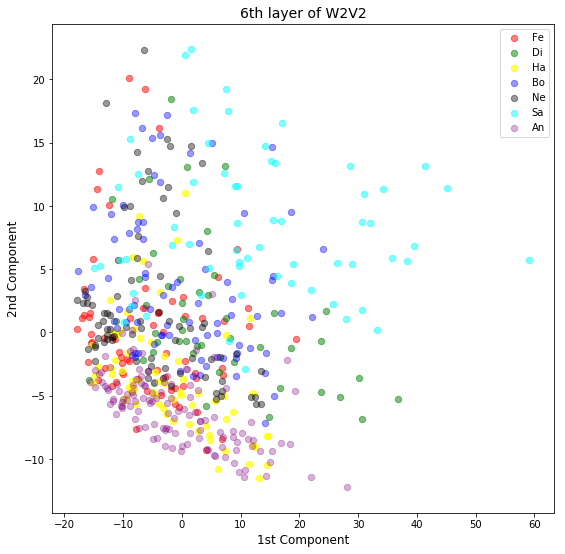

In [7]:
#plot 2d distribution

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

X = hct_feats
Y = labels

# scaler = StandardScaler()
# scaler.fit(X)
# X_scaled = scaler.transform(X)

pca = PCA(n_components=2)
pca.fit(X)
X_new = pca.transform(X)

# lda = LDA(n_components=2)
# lda.fit(X_scaled, Y)
# X_new = lda.transform(X_scaled)

ex_variance=np.var(X_new,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio

Xax = X_new[:,0]
Yax = X_new[:,1]

cdict = {0:'red',1:'green',2:'yellow',3:'blue',4:'black',5:'cyan',6:'purple'}
labl = {0:'Fe',1:'Di',2:'Ha',3:'Bo',4:'Ne',5:'Sa',6:'An'}
marker = {0:'o',1:'o',2:'o',3:'o',4:'o',5:'o',6:'o'}
alpha = {0:.5,1:.5,2:.7,3:.4,4:.4,5:.5,6:.3}

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)

fig.patch.set_facecolor('white')
for l in np.unique(Y):
    ix=np.where(Y==l)
    ax.scatter(Xax[ix], Yax[ix], c=cdict[l], s=40, label=labl[l], marker=marker[l], alpha=alpha[l])

ax.set_xlabel('1st Component', fontsize=12)
ax.set_ylabel('2nd Component', fontsize=12)
ax.set_title('6th layer of W2V2', fontsize=14)

ax.legend()
plt.show()

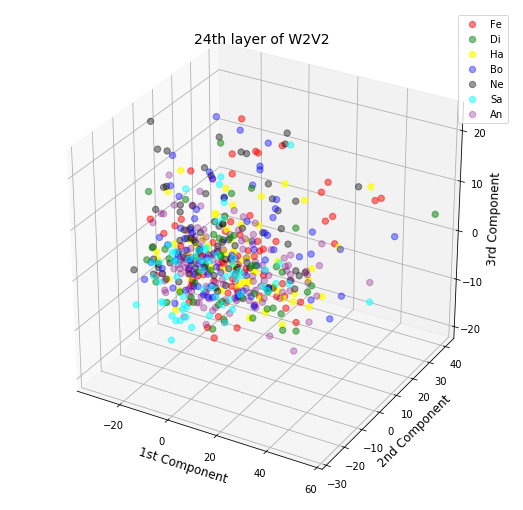

In [7]:
#plot 3d distribution

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

X = hct_feats
Y = labels

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

pca = PCA(n_components=3)
pca.fit(X_scaled) 
X_new = pca.transform(X_scaled)

# lda = LDA(n_components=3)
# lda.fit(X_scaled, Y)
# X_new = lda.transform(X_scaled)

ex_variance=np.var(X_new,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio

Xax = X_new[:,0]
Yax = X_new[:,1]
Zax = X_new[:,2]

cdict = {0:'red',1:'green',2:'yellow',3:'blue',4:'black',5:'cyan',6:'purple'}
labl = {0:'Fe',1:'Di',2:'Ha',3:'Bo',4:'Ne',5:'Sa',6:'An'}
marker = {0:'o',1:'o',2:'o',3:'o',4:'o',5:'o',6:'o'}
alpha = {0:.5,1:.5,2:.7,3:.4,4:.4,5:.5,6:.3}

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(Y):
    ix=np.where(Y==l)
    ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40, label=labl[l], marker=marker[l], alpha=alpha[l])

ax.set_xlabel("1st Component", fontsize=12)
ax.set_ylabel("2nd Component", fontsize=12)
ax.set_zlabel("3rd Component", fontsize=12)
ax.set_title('24th layer of W2V2', fontsize=14)

ax.legend()
plt.show()

In [121]:
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader

A = X_scaled[0:69]
yA = [1]*69
E = X_scaled[69:115]
yE = [1]*46
F = X_scaled[115:186]
yF = [1]*71
L = X_scaled[186:267]
yL = [1]*81
N = X_scaled[267:346]
yN = [1]*79
T = X_scaled[346:408]
yT = [1]*62
W = X_scaled[408:535]
yW = [1]*127

A_train = A[:int(69*0.7)]
A_test = A[int(69*0.7):]
E_train = E[:int(46*0.7)]
E_test = E[int(46*0.7):]
F_train = F[:int(71*0.7)]
F_test = F[int(71*0.7):]
L_train = L[:int(81*0.7)]
L_test = L[int(81*0.7):]
N_train = N[:int(79*0.7)]
N_test = N[int(79*0.7):]
T_train = T[:int(62*0.7)]
T_test = T[int(62*0.7):]
W_train = W[:int(127*0.7)]
W_test = W[int(127*0.7):]

In [122]:
#Quantitative analysis

from sklearn.metrics import precision_recall_fscore_support

#A vs other
x_train = np.vstack((A_train,E_train,F_train,L_train,N_train,T_train,W_train))
x_test = np.vstack((A_test,E_test,F_test,L_test,N_test,T_test,W_test))
y_train = yA[:int(69*0.7)] + [0]*(len(x_train)-len(yA[:int(69*0.7)]))
y_test = yA[int(69*0.7):] + [0]*(len(x_test)-len(yA[int(69*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Fear:",precision_recall_fscore_support(y_test, y_pred, average='binary'))

#E vs other
x_train = np.vstack((E_train,A_train,F_train,L_train,N_train,T_train,W_train))
x_test = np.vstack((E_test,A_test,F_test,L_test,N_test,T_test,W_test))
y_train = yE[:int(46*0.7)] + [0]*(len(x_train)-len(yE[:int(46*0.7)]))
y_test = yE[int(46*0.7):] + [0]*(len(x_test)-len(yE[int(46*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Disg:",precision_recall_fscore_support(y_test, y_pred, average='binary'))

#F vs other
x_train = np.vstack((F_train,A_train,E_train,L_train,N_train,T_train,W_train))
x_test = np.vstack((F_test,A_test,E_test,L_test,N_test,T_test,W_test))
y_train = yF[:int(71*0.7)] + [0]*(len(x_train)-len(yF[:int(71*0.7)]))
y_test = yF[int(71*0.7):] + [0]*(len(x_test)-len(yF[int(71*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Happ:",precision_recall_fscore_support(y_test, y_pred, average='binary'))

#L vs other
x_train = np.vstack((L_train,A_train,E_train,F_train,N_train,T_train,W_train))
x_test = np.vstack((L_test,A_test,E_test,F_test,N_test,T_test,W_test))
y_train = yL[:int(81*0.7)] + [0]*(len(x_train)-len(yL[:int(81*0.7)]))
y_test = yL[int(81*0.7):] + [0]*(len(x_test)-len(yL[int(81*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Bord:",precision_recall_fscore_support(y_test, y_pred, average='binary'))

#N vs other
x_train = np.vstack((N_train,A_train,E_train,F_train,L_train,T_train,W_train))
x_test = np.vstack((N_test,A_test,E_test,F_test,L_test,T_test,W_test))
y_train = yN[:int(79*0.7)] + [0]*(len(x_train)-len(yN[:int(79*0.7)]))
y_test = yN[int(79*0.7):] + [0]*(len(x_test)-len(yN[int(79*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Neut:",precision_recall_fscore_support(y_test, y_pred, average='binary'))

#T vs other
x_train = np.vstack((T_train,A_train,E_train,F_train,L_train,N_train,W_train))
x_test = np.vstack((T_test,A_test,E_test,F_test,L_test,N_test,W_test))
y_train = yT[:int(62*0.7)] + [0]*(len(x_train)-len(yT[:int(62*0.7)]))
y_test = yT[int(62*0.7):] + [0]*(len(x_test)-len(yT[int(62*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Sadn:",precision_recall_fscore_support(y_test, y_pred, average='binary'))

#W vs other
x_train = np.vstack((W_train,A_train,E_train,F_train,L_train,N_train,T_train))
x_test = np.vstack((W_test,A_test,E_test,F_test,L_test,N_test,T_test))
y_train = yW[:int(127*0.7)] + [0]*(len(x_train)-len(yW[:int(127*0.7)]))
y_test = yW[int(127*0.7):] + [0]*(len(x_test)-len(yW[int(127*0.7):]))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Ange:",precision_recall_fscore_support(y_test, y_pred, average='binary'))

#all
x_train = np.vstack((W_train,A_train,E_train,F_train,L_train,N_train,T_train))
x_test = np.vstack((W_test,A_test,E_test,F_test,L_test,N_test,T_test))
y_train = [0]*int(69*0.7) + [1]*int(46*0.7)+ [2]*int(71*0.7) + [3]*int(81*0.7) + [4]*int(79*0.7) + [5]*int(62*0.7) + [6]*int(127*0.7)
y_test = [0]*(69-int(69*0.7)) + [1]*(46-int(46*0.7))+ [2]*(71-int(71*0.7)) + [3]*(81-int(81*0.7)) + [4]*(79-int(79*0.7)) + [5]*(62-int(62*0.7)) + [6]*(127-int(127*0.7))

x_train, y_train = shuffle(x_train, y_train, random_state=1)

clf = SVC(kernel='poly')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred, target_names=['F', 'D', 'H', 'B', 'N', 'S', 'A']))
print(confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6]))

Fear: (1.0, 0.09523809523809523, 0.17391304347826084, None)
Disg: (0.5, 0.21428571428571427, 0.3, None)


/usr/lib64/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Happ: (0.0, 0.0, 0.0, None)
Bord: (0.75, 0.12, 0.20689655172413793, None)
Neut: (0.6666666666666666, 0.08333333333333333, 0.14814814814814814, None)
Sadn: (0.9333333333333333, 0.7368421052631579, 0.8235294117647058, None)
Ange: (0.5, 0.23076923076923078, 0.3157894736842105, None)
             precision    recall  f1-score   support

          F       0.21      0.95      0.35        21
          D       0.00      0.00      0.00        14
          H       0.40      0.09      0.15        22
          B       0.33      0.20      0.25        25
          N       0.00      0.00      0.00        24
          S       0.33      0.05      0.09        19
          A       0.62      0.67      0.64        39

avg / total       0.32      0.33      0.27       164

[[20  0  0  1  0  0  0]
 [14  0  0  0  0  0  0]
 [15  0  2  1  1  0  3]
 [19  0  0  5  0  0  1]
 [14  0  0  2  0  1  7]
 [ 8  0  1  1  3  1  5]
 [ 4  0  2  5  1  1 26]]


/usr/lib64/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [170]:
# ASR performance

path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

torch.cuda.empty_cache()

for file in os.listdir('.'):
    audioinput, sr = librosa.load(file, sr=16000)
    audioinput = librosa.util.fix_length(audioinput, size=143652, mode="edge") #pad to same length    
    
    #w2v features
    input_values = processor(audioinput, sampling_rate=16000, return_tensors="pt").input_values.to(device)
    logits = w2v_model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    prediction = processor.decode(predicted_ids[0])
    print(file[0:2], file[2:5], file[5], file[6], prediction)
    torch.cuda.empty_cache()

03 a01 F a der lappen liegt auf dem eisschrank
03 a01 N c der lappen liegt auf dem eisschrank
03 a01 W a der lappen liegt auf dem eisschrank
03 a02 F c das will sie am mitwoch abgeben
03 a02 N c das will sie a mittwoch abgeben
03 a02 T a das will sie am mittwoch abgeben
03 a02 W b das will sie am mittwoch abgeben
03 a02 W c das will's ja mitwoch abgeben
03 a04 A d heute abend könnte ich's ihm sagen
03 a04 F d heute abend könnt ich's ihm sagen
03 a04 L c heute abend könnt ich's ihm sagen
03 a04 N c heute abend könnt ich's ihm sagen
03 a04 T a heute abend könnte ich's ihm sagen
03 a04 W c heute abend könnt ich's ihm sagen
03 a05 A a das schwarze plattpapier befindet sich da oben neben dem holzstück
03 a05 F c das schwarze platt papier befindet sich da oben neben dem holzstück
03 a05 N d das schwarze platt papier befindet sich da oben neben dem holzstück
03 a05 T c das schwarze plattpapier befindet sich da oben neben dem holzstück
03 a05 W a das schwarze platt papier befindet sich da oben

09 b02 W c sie haben es gerade hochgetragen und jetzt gehen sie wieder runter
09 b02 W d sie haben es gerade hoch getragen und jetzt gehen sie wieder runter
09 b03 E d an den wochenenden bin ich jetzt immer nach hause gefahren und da habe agnes besucht
09 b03 F a anden wochen enden bin ich jetzt immer nach hause gefahren unda habe agnes versucht
09 b03 F d an den wochenenden bin ich jetzt immer nach hause gefahren und habe agnes besucht
09 b03 L b an den wochenenden bin ich jetzt immer nach hause gefahren und habe agnes besucht
09 b03 N b an den wochenenden bin ich jetzt immer nach hause gefahren und habe agnes besucht
09 b03 T a an den wochenenden bin ich jetzt immer nach hause gefahren und habe agnes besucht
09 b03 W b an den wochenenden bin ich jetzt immer nach hause gefahren und habe agnes besucht
09 b09 E a ich will das eben wegbringen und dann wird calwas trinken gehen
09 b09 N d ich will das ihm wegbringen und dann mit kaivers trinken gehen
09 b09 W a ich will das eben wegbringe

12 b02 E a sie haben es gerade hoch getragen und jetzt gehen sie wieder runter
12 b02 F b sie habens gerade hochgetragen und jetzt gehen sie wieder runter
12 b02 N a sie haben es gerade hochgetragen und jetzt gehen sie wieder runter
12 b02 W a sie haben es gerade hochgetragen und jetzt gehen sie wieder unter
12 b02 W b sie haben es gerade hochgetragen und jetzt gehen sie wieder runter
12 b02 W d sie haben es gerade hochgetragen und jetzt gehn sie wieder runter
12 b03 L a wochunden bin ich jetzt immer nach hause gefahren und habe agnes besucht
12 b03 T a anden wochenenden bin ich jetzt immer nach hause gefahren und habe agnes besucht
12 b09 A c ich will das eben wegbringen und dann mit karl was trinken gehen
12 b09 T d ich will das eben wegbringen und dann mit kalwas trinken gehn
12 b09 W c ich will das ihm wegbringen und dann mit kawas trinken gehen
12 b10 A c die wird auf dem platz sen wo wir sie immer hinlegen
12 b10 L d wird auf dem platz sein wo wir sie immer hinlegen
12 b10 W a di

14 b03 T a anden wochenenden bin ich jetzt immer nach hause gefahren und habe agnes besucht
14 b03 W b an den wochenenden bin ich jetzt immer nach hause gefahren und habe agnes besucht
14 b09 A c ich will das eben wegbringe und dann mit kalvas trinken gehen
14 b09 E a ich will das eben wegbringen und dann mit kalvas trinken gehen
14 b09 F c ich will das eben wegbringen und dann mit kalvas trinken gehen
14 b09 L b ich will das eben wegbringen und dann mit kaiwas trinken gehen
14 b09 T d ich will das eben wegbringen und dann mit kalvers trinken gehen
14 b09 W a ich will das eben wegbringen und dann mit kalvas trinken gehen
14 b09 W c ich will das eben wegbringen und dann mit kalvars trinken gehen
14 b10 A d wird auf dem platt sein wo wir sie immer hinlegen
14 b10 E b die wird auf dem platz sein wo wir sie immer hinlegen
14 b10 L b wie wird auf dem platz sein wo wir sie imma hinlegen
14 b10 N b die wird auf dem platz sein wo wir sie immerhinlegen
14 b10 T c die wird auf dem platz sein wo 

16 b09 E b ich will das eben wegbringen und dann mit karl was trinken gehn
16 b09 F b ich will das eben wegbringen und dann mit karlwas trinken gehn
16 b09 L a ich will das eben wegbringen und dann mit kavas trinken gehen
16 b09 L b ich will das eben wegbringen und dan mit kalvas trinken gehen
16 b09 W b ich will das eben wegbringen und dann mit kalwas trinken gehn
16 b10 A a die wird auf dem platz sein wo wir sie immer hinlegen
16 b10 E b die wird auf dem platz sein wo wir sie immer hinlegen
16 b10 F b die wird auf dem platz sein wo wir sie immer hinlegen
16 b10 L b die wird auf dem platz sein wo wir sie immer hinlegen
16 b10 T b wird auf dem platz sein wo wir sie immer hinlegen
16 b10 T d wiauf dem platz sein wo wir sie immer hinlegen
16 b10 W a die wird auf dem platz sein wo wir sie immer hinlegen
16 b10 W b die wird auf dem platz sein wo wir sie immer hinlegen


In [11]:
# calculate correlation
from scipy import signal

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
w2v_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53-german").to(device)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-xlsr-53-german")

path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

hct_A_wf = np.array([])
hct_E_wf = np.array([])
hct_F_wf = np.array([])
hct_L_wf = np.array([])
hct_N_wf = np.array([])
hct_T_wf = np.array([])
hct_W_wf = np.array([])

hct_A_wp = np.array([])
hct_E_wp = np.array([])
hct_F_wp = np.array([])
hct_L_wp = np.array([])
hct_N_wp = np.array([])
hct_T_wp = np.array([])
hct_W_wp = np.array([])

hct_A_ws = np.array([])
hct_E_ws = np.array([])
hct_F_ws = np.array([])
hct_L_ws = np.array([])
hct_N_ws = np.array([])
hct_T_ws = np.array([])
hct_W_ws = np.array([])

hct_A_ww = np.array([])
hct_E_ww = np.array([])
hct_F_ww = np.array([])
hct_L_ww = np.array([])
hct_N_ww = np.array([])
hct_T_ww = np.array([])
hct_W_ww = np.array([])

hct_A_wu = np.array([])
hct_E_wu = np.array([])
hct_F_wu = np.array([])
hct_L_wu = np.array([])
hct_N_wu = np.array([])
hct_T_wu = np.array([])
hct_W_wu = np.array([])

hct_A_f = np.array([])
hct_E_f = np.array([])
hct_F_f = np.array([])
hct_L_f = np.array([])
hct_N_f = np.array([])
hct_T_f = np.array([])
hct_W_f = np.array([])

hct_A_p = np.array([])
hct_E_p = np.array([])
hct_F_p = np.array([])
hct_L_p = np.array([])
hct_N_p = np.array([])
hct_T_p = np.array([])
hct_W_p = np.array([])

hct_A_s = np.array([])
hct_E_s = np.array([])
hct_F_s = np.array([])
hct_L_s = np.array([])
hct_N_s = np.array([])
hct_T_s = np.array([])
hct_W_s = np.array([])

hct_A_w = np.array([])
hct_E_w = np.array([])
hct_F_w = np.array([])
hct_L_w = np.array([])
hct_N_w = np.array([])
hct_T_w = np.array([])
hct_W_w = np.array([])

hct_A_u = np.array([])
hct_E_u = np.array([])
hct_F_u = np.array([])
hct_L_u = np.array([])
hct_N_u = np.array([])
hct_T_u = np.array([])
hct_W_u = np.array([])

for file in os.listdir('.'):
    audioinput, sr = librosa.load(file, sr=16000)
#     audioinput = librosa.util.fix_length(audioinput, size=143652, mode="edge") #pad to same length


#     spectral features
#     mfcc_frame = librosa.feature.mfcc(y=audioinput, sr=sr, n_fft=400, hop_length=160, n_mfcc=40)
#     mfcc_phoneme = []
#     for i in range(0,len(mfcc_frame)-3, 2):
#         mfcc_phoneme.append((mfcc_frame[i]+mfcc_frame[i+1]+mfcc_frame[i+2])/3) #phoneme level
    
#     mfcc_syllable = []
#     for i in range(0,len(mfcc_phoneme)-3, 2):
#         mfcc_syllable.append((mfcc_phoneme[i]+mfcc_phoneme[i+1]+mfcc_phoneme[i+2])/3) #syllable level    
    
#     mfcc_word=[]
#     for i in range(0, len(mfcc_syllable)-2, 1):
#         mfcc_word.append((mfcc_syllable[i]+mfcc_syllable[i+1])/2) #word level
    
#     mfcc_utter=[]
#     for i in range(0, len(mfcc_word)-5, 4):
#         mfcc_utter.append((mfcc_word[i]+mfcc_word[i+1]+mfcc_word[i+2]+mfcc_word[i+3]+mfcc_word[i+4])/5) #utterance level
    
#     kur_c = kurtosis(mfcc_frame)
#     ske_c = skew(mfcc_frame)
#     max_c = np.amax(np.array(mfcc_frame), axis=0)
#     min_c = np.amin(np.array(mfcc_frame), axis=0)
#     ave_c = np.mean(np.array(mfcc_frame), axis=0)
#     rag_c = max_c-min_c

#     for i in (kur_c, ske_c, max_c, min_c, ave_c, rag_c):
#         mfcc_utter = np.append(mfcc_utter, i)

    mels_frame = librosa.feature.melspectrogram(y=audioinput, sr=sr, n_fft=400, hop_length=320)
#     mel_del = librosa.feature.delta(mel, order=1)
#     mel_del2 = librosa.feature.delta(mel, order=2)
#     mels = np.vstack((mel, mel_del, mel_del2))
#     mels_frame = np.mean(mel, axis=1)
    mels_frame = mels_frame.T
    
    mels_phoneme = []
    for i in range(0,len(mels_frame)-3, 2):
        mels_phoneme.append((mels_frame[i]+mels_frame[i+1]+mels_frame[i+2])/3) #phoneme level
    
    mels_syllable = []
    for i in range(0,len(mels_phoneme)-3, 2):
        mels_syllable.append((mels_phoneme[i]+mels_phoneme[i+1]+mels_phoneme[i+2])/3) #syllable level    
    
    mels_word=[]
    for i in range(0, len(mels_syllable)-2, 1):
        mels_word.append((mels_syllable[i]+mels_syllable[i+1])/2) #word level
    
    mels_utter=[]
    for i in range(0, len(mels_word)-5, 4):
        mels_utter.append((mels_word[i]+mels_word[i+1]+mels_word[i+2]+mels_word[i+3]+mels_word[i+4])/5) #utterance level

#     kur_m = kurtosis(mels_frame)
#     ske_m = skew(mels_frame)
#     max_m = np.amax(np.array(mels_frame), axis=0)
#     min_m = np.amin(np.array(mels_frame), axis=0)
#     ave_m = np.mean(np.array(mels_frame), axis=0)
#     rag_m = max_m-min_m
        
#     for i in (kur_m, ske_m, max_m, min_m, ave_m, rag_m):
#         mels_utter.append(i)
    
#     prosodic features
#     eng_frame = librosa.feature.rms(y=audioinput, frame_length=400, hop_length=160)
#     eng_frame = eng_frame.reshape(eng_frame.shape[1])
#     f0_frame = librosa.yin(audioinput, frame_length=400, hop_length=160, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    
#     f0_phoneme = []
#     for i in range(0,len(f0_frame)-3,2):
#         f0_phoneme.append((f0_frame[i]+f0_frame[i+1]+f0_frame[i+2])/3) #phoneme level
#     f0_syllable = []
#     for i in range(0,len(f0_phoneme)-3,2):
#         f0_syllable.append((f0_phoneme[i]+f0_phoneme[i+1]+f0_phoneme[i+2])/3) #syllable level    
#     f0_word=[]
#     for i in range(0, len(f0_syllable)-2,1):
#         f0_word.append((f0_syllable[i]+f0_syllable[i+1])/2) #word level
#     f0_utter=[]
#     for i in range(0, len(f0_word)-5,4):
#         f0_utter.append((f0_word[i]+f0_word[i+1]+f0_word[i+2]+f0_word[i+3]+f0_word[i+4])/5) #utterance level
    
    cft_frame = mels_frame
    cft_phoneme = mels_phoneme
    cft_syllable = mels_syllable
    cft_word = mels_word
    cft_utter = mels_utter
    
#     print(len(cft_frame), len(cft_phoneme), len(cft_syllable), len(cft_word), len(cft_utter))
        
    torch.cuda.empty_cache()
    
    #w2v features
    input_values = processor(audioinput, sampling_rate=16000, return_tensors="pt").input_values.to(device)
    w2v_feats = w2v_model(input_values, output_hidden_states=True).hidden_states
    L = 15
    w2v_feats_layer = w2v_feats[L].detach()[0]
    print(w2v_feats_layer.size())
    
    cft_frame = signal.resample(cft_frame, len(w2v_feats_layer))
    print(cft_frame.shape)
    
    torch.cuda.empty_cache()
    
#     m1 = nn.AvgPool1d(3, stride=3)
#     m2 = nn.AvgPool1d(6, stride=6)
#     m3 = nn.AvgPool1d(12, stride=12)
#     m4 = nn.AvgPool1d(12, stride=12)
#     m5 = nn.AvgPool1d(38, stride=38)
        
#     w2v_f = m1(w2v_feats_layer).cpu().mean(dim=1)
#     w2v_p = m2(w2v_feats_layer).cpu().mean(dim=1)
#     w2v_s = m3(w2v_feats_layer).cpu().mean(dim=1)
#     w2v_w = m4(w2v_feats_layer).cpu().mean(dim=1)
#     w2v_u = m5(w2v_feats_layer).cpu().mean(dim=1)

    w2v_f = w2v_feats_layer.cpu().mean(dim=1)
    w2v_p = w2v_feats_layer.cpu().mean(dim=1)
    w2v_s = w2v_feats_layer.cpu().mean(dim=1)
    w2v_w = w2v_feats_layer.cpu().mean(dim=1)
    w2v_u = w2v_feats_layer.cpu().mean(dim=1)
    
#     w2v_f = signal.resample(w2v_f, len(cft_frame))
#     w2v_p = signal.resample(w2v_p, len(cft_phoneme))
#     w2v_s = signal.resample(w2v_s, len(cft_syllable))
#     w2v_w = signal.resample(w2v_w, len(cft_word))
#     w2v_u = signal.resample(w2v_u, len(cft_utter))

    hct_wf = np.array(w2v_f)
    hct_wp = np.array(w2v_p)
    hct_ws = np.array(w2v_s)                        
    hct_ww = np.array(w2v_w)
    hct_wu = np.array(w2v_u)
    hct_f = np.array(cft_frame)
    hct_p = np.array(cft_phoneme)
    hct_s = np.array(cft_syllable)
    hct_w = np.array(cft_word)
    hct_u = np.array(cft_utter)
    
    hct_wf = (hct_wf-hct_wf.mean())/(hct_wf.std())
    hct_wp = (hct_wp-hct_wp.mean())/(hct_wp.std())
    hct_ws = (hct_ws-hct_ws.mean())/(hct_ws.std())
    hct_ww = (hct_ww-hct_ww.mean())/(hct_ww.std())
    hct_wu = (hct_wu-hct_wu.mean())/(hct_wu.std())
    hct_f = (hct_f-hct_f.mean())/(hct_f.std())
    hct_p = (hct_p-hct_p.mean())/(hct_p.std())
    hct_s = (hct_s-hct_s.mean())/(hct_s.std())
    hct_w = (hct_w-hct_w.mean())/(hct_w.std())
    hct_u = (hct_u-hct_u.mean())/(hct_u.std())
    
            
    #separate accroindg to emotions
    if file[5] == 'A':
        hct_A_wf = np.append(hct_A_wf, hct_wf)
        hct_A_wf = np.reshape(hct_A_wf, (-1, hct_wf.size))
        hct_A_wp = np.append(hct_A_wp, hct_wp)
        hct_A_wp = np.reshape(hct_A_wp, (-1, hct_wp.size))
        hct_A_ws = np.append(hct_A_ws, hct_ws)
        hct_A_ws = np.reshape(hct_A_ws, (-1, hct_ws.size))
        hct_A_ww = np.append(hct_A_ww, hct_ww)
        hct_A_ww = np.reshape(hct_A_ww, (-1, hct_ww.size))
        hct_A_wu = np.append(hct_A_wu, hct_wu)
        hct_A_wu = np.reshape(hct_A_wu, (-1, hct_wu.size))
        
        hct_A_f = np.append(hct_A_f, hct_f)
        hct_A_f = np.reshape(hct_A_f, (-1, hct_f.size))
        hct_A_p = np.append(hct_A_p, hct_p)
        hct_A_p = np.reshape(hct_A_p, (-1, hct_p.size))
        hct_A_s = np.append(hct_A_s, hct_s)
        hct_A_s = np.reshape(hct_A_s, (-1, hct_s.size))
        hct_A_w = np.append(hct_A_w, hct_w)
        hct_A_w = np.reshape(hct_A_w, (-1, hct_w.size))
        hct_A_u = np.append(hct_A_u, hct_u)
        hct_A_u = np.reshape(hct_A_u, (-1, hct_u.size))
        
    elif file[5] == 'E':
        hct_E_wf = np.append(hct_E_wf, hct_wf)
        hct_E_wf = np.reshape(hct_E_wf, (-1, hct_wf.size))
        hct_E_wp = np.append(hct_E_wp, hct_wp)
        hct_E_wp = np.reshape(hct_E_wp, (-1, hct_wp.size))
        hct_E_ws = np.append(hct_E_ws, hct_ws)
        hct_E_ws = np.reshape(hct_E_ws, (-1, hct_ws.size))
        hct_E_ww = np.append(hct_E_ww, hct_ww)
        hct_E_ww = np.reshape(hct_E_ww, (-1, hct_ww.size))
        hct_E_wu = np.append(hct_E_wu, hct_wu)
        hct_E_wu = np.reshape(hct_E_wu, (-1, hct_wu.size))
        
        hct_E_f = np.append(hct_E_f, hct_f)
        hct_E_f = np.reshape(hct_E_f, (-1, hct_f.size))
        hct_E_p = np.append(hct_E_p, hct_p)
        hct_E_p = np.reshape(hct_E_p, (-1, hct_p.size))
        hct_E_s = np.append(hct_E_s, hct_s)
        hct_E_s = np.reshape(hct_E_s, (-1, hct_s.size))
        hct_E_w = np.append(hct_E_w, hct_w)
        hct_E_w = np.reshape(hct_E_w, (-1, hct_w.size))
        hct_E_u = np.append(hct_E_u, hct_u)
        hct_E_u = np.reshape(hct_E_u, (-1, hct_u.size))
        
    elif file[5] == 'F':
        hct_F_wf = np.append(hct_F_wf, hct_wf)
        hct_F_wf = np.reshape(hct_F_wf, (-1, hct_wf.size))
        hct_F_wp = np.append(hct_F_wp, hct_wp)
        hct_F_wp = np.reshape(hct_F_wp, (-1, hct_wp.size))
        hct_F_ws = np.append(hct_F_ws, hct_ws)
        hct_F_ws = np.reshape(hct_F_ws, (-1, hct_ws.size))
        hct_F_ww = np.append(hct_F_ww, hct_ww)
        hct_F_ww = np.reshape(hct_F_ww, (-1, hct_ww.size))
        hct_F_wu = np.append(hct_F_wu, hct_wu)
        hct_F_wu = np.reshape(hct_F_wu, (-1, hct_wu.size))
        
        hct_F_f = np.append(hct_F_f, hct_f)
        hct_F_f = np.reshape(hct_F_f, (-1, hct_f.size))
        hct_F_p = np.append(hct_F_p, hct_p)
        hct_F_p = np.reshape(hct_F_p, (-1, hct_p.size))
        hct_F_s = np.append(hct_F_s, hct_s)
        hct_F_s = np.reshape(hct_F_s, (-1, hct_s.size))
        hct_F_w = np.append(hct_F_w, hct_w)
        hct_F_w = np.reshape(hct_F_w, (-1, hct_w.size))
        hct_F_u = np.append(hct_F_u, hct_u)
        hct_F_u = np.reshape(hct_F_u, (-1, hct_u.size))
        
    elif file[5] == 'L':
        hct_L_wf = np.append(hct_L_wf, hct_wf)
        hct_L_wf = np.reshape(hct_L_wf, (-1, hct_wf.size))
        hct_L_wp = np.append(hct_L_wp, hct_wp)
        hct_L_wp = np.reshape(hct_L_wp, (-1, hct_wp.size))
        hct_L_ws = np.append(hct_L_ws, hct_ws)
        hct_L_ws = np.reshape(hct_L_ws, (-1, hct_ws.size))
        hct_L_ww = np.append(hct_L_ww, hct_ww)
        hct_L_ww = np.reshape(hct_L_ww, (-1, hct_ww.size))
        hct_L_wu = np.append(hct_L_wu, hct_wu)
        hct_L_wu = np.reshape(hct_L_wu, (-1, hct_wu.size))
        
        hct_L_f = np.append(hct_L_f, hct_f)
        hct_L_f = np.reshape(hct_L_f, (-1, hct_f.size))
        hct_L_p = np.append(hct_L_p, hct_p)
        hct_L_p = np.reshape(hct_L_p, (-1, hct_p.size))
        hct_L_s = np.append(hct_L_s, hct_s)
        hct_L_s = np.reshape(hct_L_s, (-1, hct_s.size))
        hct_L_w = np.append(hct_L_w, hct_w)
        hct_L_w = np.reshape(hct_L_w, (-1, hct_w.size))
        hct_L_u = np.append(hct_L_u, hct_u)
        hct_L_u = np.reshape(hct_L_u, (-1, hct_u.size))
        
    elif file[5] == 'N':
        hct_N_wf = np.append(hct_N_wf, hct_wf)
        hct_N_wf = np.reshape(hct_N_wf, (-1, hct_wf.size))
        hct_N_wp = np.append(hct_N_wp, hct_wp)
        hct_N_wp = np.reshape(hct_N_wp, (-1, hct_wp.size))
        hct_N_ws = np.append(hct_N_ws, hct_ws)
        hct_N_ws = np.reshape(hct_N_ws, (-1, hct_ws.size))
        hct_N_ww = np.append(hct_N_ww, hct_ww)
        hct_N_ww = np.reshape(hct_N_ww, (-1, hct_ww.size))
        hct_N_wu = np.append(hct_N_wu, hct_wu)
        hct_N_wu = np.reshape(hct_N_wu, (-1, hct_wu.size))
        
        hct_N_f = np.append(hct_N_f, hct_f)
        hct_N_f = np.reshape(hct_N_f, (-1, hct_f.size))
        hct_N_p = np.append(hct_N_p, hct_p)
        hct_N_p = np.reshape(hct_N_p, (-1, hct_p.size))
        hct_N_s = np.append(hct_N_s, hct_s)
        hct_N_s = np.reshape(hct_N_s, (-1, hct_s.size))
        hct_N_w = np.append(hct_N_w, hct_w)
        hct_N_w = np.reshape(hct_N_w, (-1, hct_w.size))
        hct_N_u = np.append(hct_N_u, hct_u)
        hct_N_u = np.reshape(hct_N_u, (-1, hct_u.size))
        
    elif file[5] == 'T':
        hct_T_wf = np.append(hct_T_wf, hct_wf)
        hct_T_wf = np.reshape(hct_T_wf, (-1, hct_wf.size))
        hct_T_wp = np.append(hct_T_wp, hct_wp)
        hct_T_wp = np.reshape(hct_T_wp, (-1, hct_wp.size))
        hct_T_ws = np.append(hct_T_ws, hct_ws)
        hct_T_ws = np.reshape(hct_T_ws, (-1, hct_ws.size))
        hct_T_ww = np.append(hct_T_ww, hct_ww)
        hct_T_ww = np.reshape(hct_T_ww, (-1, hct_ww.size))
        hct_T_wu = np.append(hct_T_wu, hct_wu)
        hct_T_wu = np.reshape(hct_T_wu, (-1, hct_wu.size))
        
        hct_T_f = np.append(hct_T_f, hct_f)
        hct_T_f = np.reshape(hct_T_f, (-1, hct_f.size))
        hct_T_p = np.append(hct_T_p, hct_p)
        hct_T_p = np.reshape(hct_T_p, (-1, hct_p.size))
        hct_T_s = np.append(hct_T_s, hct_s)
        hct_T_s = np.reshape(hct_T_s, (-1, hct_s.size))
        hct_T_w = np.append(hct_T_w, hct_w)
        hct_T_w = np.reshape(hct_T_w, (-1, hct_w.size))
        hct_T_u = np.append(hct_T_u, hct_u)
        hct_T_u = np.reshape(hct_T_u, (-1, hct_u.size))
        
    elif file[5] == 'W':
        hct_W_wf = np.append(hct_W_wf, hct_wf)
        hct_W_wf = np.reshape(hct_W_wf, (-1, hct_wf.size))
        hct_W_wp = np.append(hct_W_wp, hct_wp)
        hct_W_wp = np.reshape(hct_W_wp, (-1, hct_wp.size))
        hct_W_ws = np.append(hct_W_ws, hct_ws)
        hct_W_ws = np.reshape(hct_W_ws, (-1, hct_ws.size))
        hct_W_ww = np.append(hct_W_ww, hct_ww)
        hct_W_ww = np.reshape(hct_W_ww, (-1, hct_ww.size))
        hct_W_wu = np.append(hct_W_wu, hct_wu)
        hct_W_wu = np.reshape(hct_W_wu, (-1, hct_wu.size))
        
        hct_W_f = np.append(hct_W_f, hct_f)
        hct_W_f = np.reshape(hct_W_f, (-1, hct_f.size))
        hct_W_p = np.append(hct_W_p, hct_p)
        hct_W_p = np.reshape(hct_W_p, (-1, hct_p.size))
        hct_W_s = np.append(hct_W_s, hct_s)
        hct_W_s = np.reshape(hct_W_s, (-1, hct_s.size))
        hct_W_w = np.append(hct_W_w, hct_w)
        hct_W_w = np.reshape(hct_W_w, (-1, hct_w.size))
        hct_W_u = np.append(hct_W_u, hct_u)
        hct_W_u = np.reshape(hct_W_u, (-1, hct_u.size))

corr_A_f = 0
corr_E_f = 0
corr_F_f = 0
corr_L_f = 0
corr_N_f = 0
corr_T_f = 0
corr_W_f = 0
corr_A_p = 0
corr_E_p = 0
corr_F_p = 0
corr_L_p = 0
corr_N_p = 0
corr_T_p = 0
corr_W_p = 0
corr_A_s = 0
corr_E_s = 0
corr_F_s = 0
corr_L_s = 0
corr_N_s = 0
corr_T_s = 0
corr_W_s = 0
corr_A_w = 0
corr_E_w = 0
corr_F_w = 0
corr_L_w = 0
corr_N_w = 0
corr_T_w = 0
corr_W_w = 0
corr_A_u = 0
corr_E_u = 0
corr_F_u = 0
corr_L_u = 0
corr_N_u = 0
corr_T_u = 0
corr_W_u = 0

# Frame level correlation computation
for i in range(len(hct_A_wf)):
    corr, _, _ = pwcca.compute_pwcca(hct_A_wf[i].reshape(1, -1), hct_A_f[i].reshape(1, -1), epsilon=1e-10)
    corr_A_f += corr
for i in range(len(hct_E_wf)):
    corr, _, _ = pwcca.compute_pwcca(hct_E_wf[i].reshape(1, -1), hct_E_f[i].reshape(1, -1), epsilon=1e-10)
    corr_E_f += corr
for i in range(len(hct_F_wf)):
    corr, _, _ = pwcca.compute_pwcca(hct_F_wf[i].reshape(1, -1), hct_F_f[i].reshape(1, -1), epsilon=1e-10)
    corr_F_f += corr
for i in range(len(hct_L_wf)):
    corr, _, _ = pwcca.compute_pwcca(hct_L_wf[i].reshape(1, -1), hct_L_f[i].reshape(1, -1), epsilon=1e-10)
    corr_L_f += corr
for i in range(len(hct_N_wf)):
    corr, _, _ = pwcca.compute_pwcca(hct_N_wf[i].reshape(1, -1), hct_N_f[i].reshape(1, -1), epsilon=1e-10)
    corr_N_f += corr
for i in range(len(hct_T_wf)):
    corr, _, _ = pwcca.compute_pwcca(hct_T_wf[i].reshape(1, -1), hct_T_f[i].reshape(1, -1), epsilon=1e-10)
    corr_T_f += corr
for i in range(len(hct_W_wf)):
    corr, _, _ = pwcca.compute_pwcca(hct_W_wf[i].reshape(1, -1), hct_W_f[i].reshape(1, -1), epsilon=1e-10)
    corr_W_f += corr
    
# Phoneme level correlation computation
for i in range(len(hct_A_wp)):
    corr, _, _ = pwcca.compute_pwcca(hct_A_wp[i].reshape(1, -1), hct_A_p[i].reshape(1, -1), epsilon=1e-10)
    corr_A_p += corr
for i in range(len(hct_E_wp)):
    corr, _, _ = pwcca.compute_pwcca(hct_E_wp[i].reshape(1, -1), hct_E_p[i].reshape(1, -1), epsilon=1e-10)
    corr_E_p += corr
for i in range(len(hct_F_wp)):
    corr, _, _ = pwcca.compute_pwcca(hct_F_wp[i].reshape(1, -1), hct_F_p[i].reshape(1, -1), epsilon=1e-10)
    corr_F_p += corr
for i in range(len(hct_L_wp)):
    corr, _, _ = pwcca.compute_pwcca(hct_L_wp[i].reshape(1, -1), hct_L_p[i].reshape(1, -1), epsilon=1e-10)
    corr_L_p += corr
for i in range(len(hct_N_wp)):
    corr, _, _ = pwcca.compute_pwcca(hct_N_wp[i].reshape(1, -1), hct_N_p[i].reshape(1, -1), epsilon=1e-10)
    corr_N_p += corr
for i in range(len(hct_T_wp)):
    corr, _, _ = pwcca.compute_pwcca(hct_T_wp[i].reshape(1, -1), hct_T_p[i].reshape(1, -1), epsilon=1e-10)
    corr_T_p += corr
for i in range(len(hct_W_wp)):
    corr, _, _ = pwcca.compute_pwcca(hct_W_wp[i].reshape(1, -1), hct_W_p[i].reshape(1, -1), epsilon=1e-10)
    corr_W_p += corr
                         
# Syllable level correlation computation
for i in range(len(hct_A_ws)):
    corr, _, _ = pwcca.compute_pwcca(hct_A_ws[i].reshape(1, -1), hct_A_s[i].reshape(1, -1), epsilon=1e-10)
    corr_A_s += corr
for i in range(len(hct_E_ws)):
    corr, _, _ = pwcca.compute_pwcca(hct_E_ws[i].reshape(1, -1), hct_E_s[i].reshape(1, -1), epsilon=1e-10)
    corr_E_s += corr
for i in range(len(hct_F_ws)):
    corr, _, _ = pwcca.compute_pwcca(hct_F_ws[i].reshape(1, -1), hct_F_s[i].reshape(1, -1), epsilon=1e-10)
    corr_F_s += corr
for i in range(len(hct_L_ws)):
    corr, _, _ = pwcca.compute_pwcca(hct_L_ws[i].reshape(1, -1), hct_L_s[i].reshape(1, -1), epsilon=1e-10)
    corr_L_s += corr
for i in range(len(hct_N_ws)):
    corr, _, _ = pwcca.compute_pwcca(hct_N_ws[i].reshape(1, -1), hct_N_s[i].reshape(1, -1), epsilon=1e-10)
    corr_N_s += corr
for i in range(len(hct_T_ws)):
    corr, _, _ = pwcca.compute_pwcca(hct_T_ws[i].reshape(1, -1), hct_T_s[i].reshape(1, -1), epsilon=1e-10)
    corr_T_s += corr
for i in range(len(hct_W_ws)):
    corr, _, _ = pwcca.compute_pwcca(hct_W_ws[i].reshape(1, -1), hct_W_s[i].reshape(1, -1), epsilon=1e-10)
    corr_W_s += corr
    
# word level correlation computation
for i in range(len(hct_A_ww)):
    corr, _, _ = pwcca.compute_pwcca(hct_A_ww[i].reshape(1, -1), hct_A_w[i].reshape(1, -1), epsilon=1e-10)
    corr_A_w += corr
for i in range(len(hct_E_ww)):
    corr, _, _ = pwcca.compute_pwcca(hct_E_ww[i].reshape(1, -1), hct_E_w[i].reshape(1, -1), epsilon=1e-10)
    corr_E_w += corr
for i in range(len(hct_F_ww)):
    corr, _, _ = pwcca.compute_pwcca(hct_F_ww[i].reshape(1, -1), hct_F_w[i].reshape(1, -1), epsilon=1e-10)
    corr_F_w += corr
for i in range(len(hct_L_ww)):
    corr, _, _ = pwcca.compute_pwcca(hct_L_ww[i].reshape(1, -1), hct_L_w[i].reshape(1, -1), epsilon=1e-10)
    corr_L_w += corr
for i in range(len(hct_N_ww)):
    corr, _, _ = pwcca.compute_pwcca(hct_N_ww[i].reshape(1, -1), hct_N_w[i].reshape(1, -1), epsilon=1e-10)
    corr_N_w += corr
for i in range(len(hct_T_ww)):
    corr, _, _ = pwcca.compute_pwcca(hct_T_ww[i].reshape(1, -1), hct_T_w[i].reshape(1, -1), epsilon=1e-10)
    corr_T_w += corr
for i in range(len(hct_W_ww)):
    corr, _, _ = pwcca.compute_pwcca(hct_W_ww[i].reshape(1, -1), hct_W_w[i].reshape(1, -1), epsilon=1e-10)
    corr_W_w += corr
    
# utterance level correlation computation
for i in range(len(hct_A_wu)):
    corr, _, _ = pwcca.compute_pwcca(hct_A_wu[i].reshape(1, -1), hct_A_u[i].reshape(1, -1), epsilon=1e-10)
    corr_A_u += corr
for i in range(len(hct_E_wu)):
    corr, _, _ = pwcca.compute_pwcca(hct_E_wu[i].reshape(1, -1), hct_E_u[i].reshape(1, -1), epsilon=1e-10)
    corr_E_u += corr
for i in range(len(hct_F_wu)):
    corr, _, _ = pwcca.compute_pwcca(hct_F_wu[i].reshape(1, -1), hct_F_u[i].reshape(1, -1), epsilon=1e-10)
    corr_F_u += corr
for i in range(len(hct_L_wu)):
    corr, _, _ = pwcca.compute_pwcca(hct_L_wu[i].reshape(1, -1), hct_L_u[i].reshape(1, -1), epsilon=1e-10)
    corr_L_u += corr
for i in range(len(hct_N_wu)):
    corr, _, _ = pwcca.compute_pwcca(hct_N_wu[i].reshape(1, -1), hct_N_u[i].reshape(1, -1), epsilon=1e-10)
    corr_N_u += corr
for i in range(len(hct_T_wu)):
    corr, _, _ = pwcca.compute_pwcca(hct_T_wu[i].reshape(1, -1), hct_T_u[i].reshape(1, -1), epsilon=1e-10)
    corr_T_u += corr
for i in range(len(hct_W_wu)):
    corr, _, _ = pwcca.compute_pwcca(hct_W_wu[i].reshape(1, -1), hct_W_u[i].reshape(1, -1), epsilon=1e-10)
    corr_W_u += corr


print('Layer ' + str(L))

print('-----Frame level-----')
print('Fear:', corr_A_f/len(hct_A_wf))
print('Disg:', corr_E_f/len(hct_E_wf))
print('Happ:', corr_F_f/len(hct_F_wf))
print('Bord:', corr_L_f/len(hct_L_wf))
print('Neut:', corr_N_f/len(hct_N_wf))
print('Sadn:', corr_T_f/len(hct_T_wf))
print('Ange:', corr_W_f/len(hct_W_wf))

print('-----Phoneme level-----')
print('Fear:', corr_A_p/len(hct_A_wp))
print('Disg:', corr_E_p/len(hct_E_wp))
print('Happ:', corr_F_p/len(hct_F_wp))
print('Bord:', corr_L_p/len(hct_L_wp))
print('Neut:', corr_N_p/len(hct_N_wp))
print('Sadn:', corr_T_p/len(hct_T_wp))
print('Ange:', corr_W_p/len(hct_W_wp))
                         
print('-----Syllable level-----')
print('Fear:', corr_A_s/len(hct_A_ws))
print('Disg:', corr_E_s/len(hct_E_ws))
print('Happ:', corr_F_s/len(hct_F_ws))
print('Bord:', corr_L_s/len(hct_L_ws))
print('Neut:', corr_N_s/len(hct_N_ws))
print('Sadn:', corr_T_s/len(hct_T_ws))
print('Ange:', corr_W_s/len(hct_W_ws))

print('-----Word level-----')
print('Fear:', corr_A_w/len(hct_A_ww))
print('Disg:', corr_E_w/len(hct_E_ww))
print('Happ:', corr_F_w/len(hct_F_ww))
print('Bord:', corr_L_w/len(hct_L_ww))
print('Neut:', corr_N_w/len(hct_N_ww))
print('Sadn:', corr_T_w/len(hct_T_ww))
print('Ange:', corr_W_w/len(hct_W_ww))

print('-----Utterance level-----')
print('Fear:', corr_A_u/len(hct_A_wu))
print('Disg:', corr_E_u/len(hct_E_wu))
print('Happ:', corr_F_u/len(hct_F_wu))
print('Bord:', corr_L_u/len(hct_L_wu))
print('Neut:', corr_N_u/len(hct_N_wu))
print('Sadn:', corr_T_u/len(hct_T_wu))
print('Ange:', corr_W_u/len(hct_W_wu))

torch.Size([94, 1024])
(94, 128)
torch.Size([80, 1024])
(80, 128)
torch.Size([93, 1024])
(93, 128)
torch.Size([100, 1024])
(100, 128)


ValueError: cannot reshape array of size 194 into shape (100)

In [38]:
# calculate correlation

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
w2v_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53-german").to(device)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-xlsr-53-german")

path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

hct_A = np.array([])
hct_E = np.array([])
hct_F = np.array([])
hct_L = np.array([])
hct_N = np.array([])
hct_T = np.array([])
hct_W = np.array([])

w2v_A = np.array([])
w2v_E = np.array([])
w2v_F = np.array([])
w2v_L = np.array([])
w2v_N = np.array([])
w2v_T = np.array([])
w2v_W = np.array([])


for file in os.listdir('.'):
    audioinput, sr = librosa.load(file, sr=16000)
    
    feats = smile.process_signal(audioinput, sr)
    egmaps = []

# frequency
#     egmaps.append(feats['F0semitoneFrom27.5Hz_sma3nz'].values)
#     egmaps.append(feats['jitterLocal_sma3nz'].values)
#     egmaps.append(feats['F1frequency_sma3nz'].values)
#     egmaps.append(feats['F1bandwidth_sma3nz'].values)
#     egmaps.append(feats['F2frequency_sma3nz'].values)
#     egmaps.append(feats['F3frequency_sma3nz'].values)

# energy
#     egmaps.append(feats['Loudness_sma3'].values)
#     egmaps.append(feats['shimmerLocaldB_sma3nz'].values)
#     egmaps.append(feats['HNRdBACF_sma3nz'].values)

# spectral
    egmaps.append(feats['alphaRatio_sma3'].values)
    egmaps.append(feats['hammarbergIndex_sma3'].values)
    egmaps.append(feats['slope0-500_sma3'].values)
    egmaps.append(feats['slope500-1500_sma3'].values)
    egmaps.append(feats['logRelF0-H1-H2_sma3nz'].values)
    egmaps.append(feats['logRelF0-H1-A3_sma3nz'].values)
    egmaps.append(feats['F1amplitudeLogRelF0_sma3nz'].values)
    egmaps.append(feats['F2amplitudeLogRelF0_sma3nz'].values)
    egmaps.append(feats['F3amplitudeLogRelF0_sma3nz'].values)
    

#     spectral features
#     mfcc = librosa.feature.mfcc(y=audioinput, sr=sr, n_fft=400, hop_length=160, n_mfcc=40)

#     mel = librosa.feature.melspectrogram(y=audioinput, sr=sr, n_fft=400, hop_length=160)
#     mel_del = librosa.feature.delta(mel, order=1) 暂时无用
#     mel_del2 = librosa.feature.delta(mel, order=2) 暂时无用
#     mels = np.vstack((mel, mel_del, mel_del2)) 暂时无用
#     mels_frame = np.mean(mels, axis=1) 暂时无用
#     hct = mel.T

#     f0 = librosa.yin(audioinput, frame_length=400, hop_length=160, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
#     mels_frame = f0.T
#     mels_frame = mels_frame.reshape(-1, 1)


    hct = np.array(egmaps).T

    torch.cuda.empty_cache()
    
    #w2v features
    input_values = processor(audioinput, sampling_rate=16000, return_tensors="pt").input_values.to(device)
    w2v_feats = w2v_model(input_values, output_hidden_states=True).hidden_states
    L = 23
    w2v = np.array(w2v_feats[L].detach()[0].cpu())
    hct = signal.resample(hct, len(w2v))
            
    torch.cuda.empty_cache()
        
#     mels_phoneme = []
#     for i in range(0,len(mels_frame)-3, 3):
#         mels_phoneme.append((mels_frame[i]+mels_frame[i+1]+mels_frame[i+2])/3) #phoneme level
#     mels_phoneme = np.array(mels_phoneme)
    
#     mels_syllable = []
#     for i in range(0,len(mels_phoneme)-3, 3):
#         mels_syllable.append((mels_phoneme[i]+mels_phoneme[i+1]+mels_phoneme[i+2])/3) #syllable level
#     mels_syllable = np.array(mels_syllable)
    
#     mels_word=[]
#     for i in range(0, len(mels_syllable)-2, 2):
#         mels_word.append((mels_syllable[i]+mels_syllable[i+1])/2) #word level
#     mels_word = np.array(mels_word)
    
#     mels_utter=[]
#     for i in range(0, len(mels_word)-5, 5):
#         mels_utter.append((mels_word[i]+mels_word[i+1]+mels_word[i+2]+mels_word[i+3]+mels_word[i+4])/5) #utterance level
#     mels_utter = np.array(mels_utter)
            
    #separate accroindg to emotions
    if file[5] == 'A':
        if len(hct_A) > 0:
            hct_A = np.concatenate((hct_A, hct), axis=0)
            w2v_A = np.concatenate((w2v_A, w2v), axis=0)
        else:
            hct_A = hct
            w2v_A = w2v
        
    elif file[5] == 'E':
        if len(hct_E) > 0:
            hct_E = np.concatenate((hct_E, hct), axis=0)
            w2v_E = np.concatenate((w2v_E, w2v), axis=0)
        else:
            hct_E = hct
            w2v_E = w2v
        
    elif file[5] == 'F':
        if len(hct_F) > 0:
            hct_F = np.concatenate((hct_F, hct), axis=0)
            w2v_F = np.concatenate((w2v_F, w2v), axis=0)
        else:
            hct_F = hct
            w2v_F = w2v
        
    elif file[5] == 'L':
        if len(hct_L) > 0:
            hct_L = np.concatenate((hct_L, hct), axis=0)
            w2v_L = np.concatenate((w2v_L, w2v), axis=0)
        else:
            hct_L = hct
            w2v_L = w2v
        
    elif file[5] == 'N':
        if len(hct_N) > 0:
            hct_N = np.concatenate((hct_N, hct), axis=0)
            w2v_N = np.concatenate((w2v_N, w2v), axis=0)
        else:
            hct_N = hct
            w2v_N = w2v
        
    elif file[5] == 'T':
        if len(hct_T) > 0:
            hct_T = np.concatenate((hct_T, hct), axis=0)
            w2v_T = np.concatenate((w2v_T, w2v), axis=0)
        else:
            hct_T = hct
            w2v_T = w2v
        
    elif file[5] == 'W':
        if len(hct_W) > 0:
            hct_W = np.concatenate((hct_W, hct), axis=0)
            w2v_W = np.concatenate((w2v_W, w2v), axis=0)
        else:
            hct_W = hct
            w2v_W = w2v

# hct_A = normalize(hct_A, axis=0) 
# hct_E = normalize(hct_E, axis=0)
# hct_F = normalize(hct_F, axis=0)
# hct_L = normalize(hct_L, axis=0)
# hct_N = normalize(hct_N, axis=0)
# hct_T = normalize(hct_T, axis=0)
# hct_W = normalize(hct_W, axis=0)

# w2v_A = normalize(w2v_A, axis=0) 
# w2v_E = normalize(w2v_E, axis=0)
# w2v_F = normalize(w2v_F, axis=0)
# w2v_L = normalize(w2v_L, axis=0)
# w2v_N = normalize(w2v_N, axis=0)
# w2v_T = normalize(w2v_T, axis=0)
# w2v_W = normalize(w2v_W, axis=0)

corr_frame_A, _, _ = pwcca.compute_pwcca(hct_A.T, w2v_A.T, epsilon=1e-10)
corr_frame_E, _, _ = pwcca.compute_pwcca(hct_E.T, w2v_E.T, epsilon=1e-10)
corr_frame_F, _, _ = pwcca.compute_pwcca(hct_F.T, w2v_F.T, epsilon=1e-10)
corr_frame_L, _, _ = pwcca.compute_pwcca(hct_L.T, w2v_L.T, epsilon=1e-10)
corr_frame_N, _, _ = pwcca.compute_pwcca(hct_N.T, w2v_N.T, epsilon=1e-10)
corr_frame_T, _, _ = pwcca.compute_pwcca(hct_T.T, w2v_T.T, epsilon=1e-10)
corr_frame_W, _, _ = pwcca.compute_pwcca(hct_W.T, w2v_W.T, epsilon=1e-10)

print('Layer ' + str(L))

print('-----Frame level-----')
print(corr_frame_A)
print(corr_frame_E)
print(corr_frame_F)
print(corr_frame_L)
print(corr_frame_N)
print(corr_frame_T)
print(corr_frame_W)

Layer 23
-----Frame level-----
0.8372993567367414
0.835271436635811
0.8329749597190105
0.8321538130262183
0.844212026478092
0.8473534096067803
0.8267945826248442


In [ ]:
spectral

Layer 0
-----Frame level-----
0.9240742594101533
0.9146051916126743
0.8915224029011595
0.915646809796941
0.9263184864931312
0.9075099414583477
0.8793276644148267

Layer 1
-----Frame level-----
0.924922746359989
0.922565110681835
0.9128627338053081
0.9318029927483636
0.9195250884801145
0.9125487859817495
0.8964906037011673

Layer 2
-----Frame level-----
0.9161786136816287
0.91046022492771
0.9099529776251513
0.913914267885877
0.9252604646304388
0.9106888398107263
0.8910844855506385

Layer 3
-----Frame level-----
0.9180196383705695
0.902694318406546
0.9030610187586463
0.925073142606932
0.9047105737753512
0.9110499735438072
0.8816107430861595

Layer 4
-----Frame level-----
0.8901501616920099
0.9012203345091112
0.8997573498806116
0.9046805662275984
0.8978674835471995
0.9025109161881945
0.8872612368996403

Layer 5
-----Frame level-----
0.8818582069989828
0.8939195571518792
0.8878968774362245
0.8981331687079799
0.901573557481164
0.9009567075016218
0.8713100997882616

Layer 6
-----Frame level-----
0.882823158879502
0.8890510193728499
0.8808847284795892
0.9004929057301779
0.9090409493028405
0.8870962247210417
0.8654528197879806

Layer 7
-----Frame level-----
0.8941068049877022
0.8697370085028788
0.8762893929400086
0.882534610717968
0.89219362004647
0.8909759015563139
0.8605359909737744

Layer 8
-----Frame level-----
0.871230173933445
0.8642573364233572
0.8841103929158154
0.8866734770418743
0.882432628742215
0.8782165170419245
0.8681470503114205

Layer 9
-----Frame level-----
0.8873476879849428
0.8610786276643592
0.8619773496859299
0.8755764568443014
0.8785744563234518
0.8723994312394606
0.8607352874195966

Layer 10
-----Frame level-----
0.8836507348855167
0.8595213921079538
0.862681331321723
0.8668237175373592
0.878410214234092
0.8718061865847758
0.8444294524526631

Layer 11
-----Frame level-----
0.8737013221921394
0.8575696067083295
0.8736111958095018
0.869348760574446
0.8748532245236579
0.859202048261863
0.8558316347024943

Layer 12
-----Frame level-----
0.857400724990987
0.8714956175985706
0.8577403094437063
0.8677715517536061
0.874362422769928
0.86950654291362
0.8354882570676252

Layer 13
-----Frame level-----
0.8613819977344228
0.8617633582865805
0.8784869172283328
0.8674089945890328
0.874155232035297
0.8726634953313855
0.8530359732942483

Layer 14
-----Frame level-----
0.870079008892719
0.8694822286654389
0.8617547231440188
0.8664475929590228
0.8734425427076051
0.8685749111034364
0.8549367865165305

Layer 15
-----Frame level-----
0.8707193744606292
0.854266424236636
0.8624040195407198
0.8670954788030041
0.8742570933787872
0.860958867124313
0.8556071003357485

Layer 16
-----Frame level-----
0.8723293402153046
0.8560478766834113
0.8631619534368082
0.8692085701503645
0.8750156400781949
0.8640848436332798
0.8423843421288854

Layer 17
-----Frame level-----
0.8716089622417307
0.8674404894872613
0.8617021487070446
0.8669657621593762
0.8731718920017744
0.8649998850911765
0.8409563743545936

Layer 18
-----Frame level-----
0.8585312866194387
0.8527573720701397
0.8626285471394163
0.8596335348414151
0.872035962940521
0.8635416162878717
0.8508850815468035

Layer 19
-----Frame level-----
0.847557189078124
0.8527562557848223
0.856215378854476
0.8573954291992016
0.8627716401500856
0.8667982606544278
0.8334133906533907

Layer 20
-----Frame level-----
0.853107648033272
0.849297629421113
0.841938179850396
0.849367244853906
0.8558809506811383
0.8598819821871332
0.8250754330388251

Layer 21
-----Frame level-----
0.8448095009561446
0.8422089035359938
0.8325021180836099
0.8423175349646561
0.850667120282009
0.8488642701958304
0.8169945795077213

Layer 22
-----Frame level-----
0.8351640842812779
0.8353468241559888
0.8277000275073446
0.8317366750462755
0.8450101701403557
0.8439961620354803
0.8026388949908747

Layer 24
-----Frame level-----
0.830111172349942
0.8209443739240357
0.8258090730164189
0.8232275183335118
0.8361989231386092
0.8378781685838833
0.8173444971376043

In [ ]:
mfcc

Layer 0
-----Frame level-----
0.8564243153561564
0.8580600770800715
0.8373128190643357
0.8616643224813184
0.8598165946965451
0.8504944860539412
0.8303339756977379

Layer 1
-----Frame level-----
0.8494518708309126
0.8573878029090514
0.8377954270697088
0.850460871929321
0.8585655841277927
0.8431533780976732
0.826968147470083

Layer 2
-----Frame level-----
0.8375184953802695
0.8366817354201014
0.8233956600719146
0.8333813454583272
0.8417610136003693
0.8454671753045273
0.8110749586977383

Layer 3
-----Frame level-----
0.8246588100832245
0.827384495823825
0.8030451129150571
0.8255625207827599
0.8342873975670666
0.8355286988369207
0.7823163539932645

Layer 4
-----Frame level-----
0.8109897411724607
0.8252506266360813
0.7958481721500708
0.809167586888804
0.8208740033164198
0.8139476937011747
0.7639720847406319

Layer 5
-----Frame level-----
0.791763909589175
0.7954821338042811
0.7801103022078515
0.7922731103477347
0.7983711022287184
0.8085255492148036
0.7532805178979628

Layer 6
-----Frame level-----
0.7899014823239086
0.7975868401034214
0.7691116600843274
0.7955340027806823
0.7953402325922947
0.7965753486634931
0.7338666605796218

Layer 7
-----Frame level-----
0.7799968448600365
0.7933474941612436
0.7547070396868332
0.7779161586983543
0.7746489290565626
0.7985089435418553
0.7286448513438439

Layer 8
-----Frame level-----
0.7725075879490564
0.7894404079456554
0.746171438698969
0.7747979999401008
0.7725200383877544
0.7966913048867721
0.7168433387899106

Layer 9
-----Frame level-----
0.7705706444795662
0.7764000746803039
0.7496356434916027
0.7731776706967307
0.7695368959023994
0.7799408124129832
0.710425775233853

Layer 10
-----Frame level-----
0.7691698494331467
0.7867124433543722
0.7542662620776065
0.7595811982032554
0.7733282977675666
0.7865442841502308
0.7070453546805109

Layer 11
-----Frame level-----
0.7600931577923717
0.7909811660192203
0.751592885465064
0.7653759418167665
0.7658946340029189
0.7724718227555074
0.7055024872571638

Layer 12
-----Frame level-----
0.7659622067655348
0.7893255079835879
0.7492991045641
0.7680642555958822
0.7657941749184927
0.774204663823759
0.7057055924694149

Layer 13
-----Frame level-----
0.7709882333778978
0.7865741146556231
0.748138885405026
0.7653860405563029
0.7688518090335303
0.7710456692683165
0.70731075486956

Layer 14
-----Frame level-----
0.756412098986208
0.7756281751953188
0.749698337680123
0.7573809772099611
0.7598423512982794
0.7665758739668498
0.6966459744982652

Layer 15
-----Frame level-----
0.7522888238358897
0.7704167357816937
0.737405628971824
0.7510846014361315
0.7700175429264746
0.7642249285568217
0.7045309570717568

Layer 16
-----Frame level-----
0.7523259324940208
0.7718508742373095
0.7368297932872001
0.7495111624059273
0.7554308192328008
0.7658030624080321
0.7031464783205176

Layer 17
-----Frame level-----
0.7561729700253306
0.7630822839303407
0.7354568532086267
0.7439833213066724
0.7524662516712775
0.7613706813072227
0.6924193179803715

Layer 18
-----Frame level-----
0.7514830286479778
0.7655778396438122
0.7269940641648511
0.7409435944179013
0.742587965310411
0.7598284918702974
0.6944281891045652

Layer 19
-----Frame level-----
0.736292241897843
0.7536782076178293
0.7127562289966767
0.7315938327701162
0.7459254145830321
0.7503864213920918
0.6829096805570259

Layer 20
-----Frame level-----
0.7297416147719078
0.7500609949820813
0.7014982049427851
0.7146895733849635
0.7343650480403083
0.7410370368226987
0.6725624236662092

Layer 21
-----Frame level-----
0.7155829940461695
0.736621218535552
0.6909344137489768
0.709416020931158
0.7228488248597007
0.7309799628376612
0.6538551141741242

Layer 22
-----Frame level-----
0.7083042176259173
0.7336893345893901
0.6828127312332433
0.6933407050793419
0.7093239632845887
0.72511289762007
0.6459345407894697

Layer 23
-----Frame level-----
0.7119321931953684
0.733263545371321
0.6871270728912648
0.6978523886945434
0.7187802448994867
0.726314861212131
0.6464612988870512

Layer 24
-----Frame level-----
0.7105755660597041
0.7231118604572937
0.6789776574362052
0.6888588428487633
0.7076003157526307
0.7298696168822769
0.6435297776783264

In [ ]:
energy

Layer 0
-----Frame level-----
0.7946369622491489
0.8111842525650415
0.7783939209836512
0.7902525415157988
0.7746134729497907
0.7814428609005786
0.7518591339314706

Layer 1
-----Frame level-----
0.8046540559696966
0.820132787675222
0.789128170097152
0.8014023224468997
0.7878643292754189
0.7969784067415298
0.7566147555292544

Layer 2
-----Frame level-----
0.8025130322315848
0.8139656714472108
0.7916005751150983
0.8008989977694223
0.7854284087663463
0.7949722231354808
0.755650381656826

Layer 3
-----Frame level-----
0.7991212810114379
0.8076622977668593
0.7888180573150655
0.7911592089531554
0.778491731363256
0.7891899463807955
0.7549605832549806

Layer 4
-----Frame level-----
0.7917443734413065
0.8039019524789859
0.7864951507771241
0.7865128877763468
0.7730530548133088
0.7846418995789283
0.7556669214156545

Layer 5
-----Frame level-----
0.7887439251329429
0.8003784551254489
0.7849145278970768
0.7797312776678096
0.7700298589252377
0.7802318362444104
0.749845405120011

Layer 6
-----Frame level-----
0.7817131672192467
0.7978502739340207
0.7856301362482605
0.7749697127959511
0.7714787873010642
0.7778354766748062
0.7462219734219591

Layer 7
-----Frame level-----
0.7774796757530787
0.7938481506709748
0.783279755753538
0.7736805219791474
0.7699896979138949
0.7753978357162098
0.743823178698257

Layer 8
-----Frame level-----
0.7735726571293313
0.7893894154479877
0.7776044142039187
0.7707582283909195
0.7668577094916977
0.7696245209238128
0.7380993167507115

Layer 9
-----Frame level-----
0.7716125195248855
0.7881428036045861
0.7762650673012366
0.7672044598863396
0.7658479457656877
0.7691742781122478
0.7365269191592319

Layer 10
-----Frame level-----
0.7748026421857959
0.7921227756723658
0.7776640275865925
0.7636853089293145
0.767168372987979
0.7694886396417885
0.7347821186623051

Layer 11
-----Frame level-----
0.777507079128947
0.7901319190324425
0.7767669923959603
0.7648440894885344
0.77238214747864
0.7722394638858072
0.7322681454446693

Layer 12
-----Frame level-----
0.7715107799742302
0.7902758810303026
0.7762821866269041
0.765738743326955
0.7743712072622493
0.7711528810049827
0.7306651965816433

Layer 13
-----Frame level-----
0.7694811789731786
0.7876921038959744
0.7759262335062711
0.7640001482313116
0.7754542795923522
0.7725153392319445
0.7305562279271869

Layer 14
-----Frame level-----
0.7689869274114927
0.7869860210668957
0.7733333893353981
0.764155760023776
0.7714650888328474
0.7677823837934723
0.7287421864014243

Layer 15
-----Frame level-----
0.7696368649496022
0.7888191973147458
0.7745640947138686
0.7638131739012557
0.774779221290063
0.7716167359650993
0.7328486872234496

Layer 16
-----Frame level-----
0.7677901774608081
0.787724281158662
0.7763561966255756
0.7648494864648473
0.7731126238912522
0.7698089465003684
0.7327349485334719

Layer 17
-----Frame level-----
0.7728922604287407
0.7879967619986232
0.774404887222081
0.7654436585737492
0.7737371506146847
0.7705483823947745
0.7302412094819268

Layer 18
-----Frame level-----
0.7661214532762275
0.7847470250606617
0.7678306251246976
0.7630475614436716
0.7734647523577862
0.7652444411384092
0.7263736452562151

Layer 19
-----Frame level-----
0.7567259640066308
0.776881284097952
0.762090537587059
0.7545834935391238
0.7660615808078317
0.7612849864930631
0.7174475321633287

Layer 20
-----Frame level-----
0.7488043853603167
0.7698671013027769
0.7545943315704136
0.7410728036706558
0.7576540776275474
0.7552543243207882
0.7106693761781395

Layer 21
-----Frame level-----
0.7400482165505621
0.7608865957387569
0.7432387725750567
0.7335204031282461
0.7525858759150548
0.7494513859299989
0.7011920973797384

Layer 22
-----Frame level-----
0.7320543714010481
0.7582803097094392
0.7363762271125834
0.7302836376679782
0.7447376626827824
0.7467412698845455
0.696815504739476

Layer 23
-----Frame level-----
0.7353147817454635
0.7579588099677554
0.7369558035180312
0.731797919863177
0.7434582574472407
0.7485526887166112
0.6972690624796313

Layer 24
-----Frame level-----
0.7370988702555303
0.7528060139019005
0.7344364959591949
0.7277750942923893
0.7486528325562617
0.7494068769175942
0.6902355711832296

In [ ]:
frequency

Layer 0
-----Frame level-----
0.6970149924135699
0.728378410538828
0.6788122726483556
0.7048308343826919
0.720291154566267
0.6918079793937993
0.6137402723754731

Layer 1
-----Frame level-----
0.69864222918773
0.726574095458451
0.6848651981422192
0.7085664874873169
0.7184061654992042
0.6950429035795187
0.6198422757068415

Layer 2
-----Frame level-----
0.6984285101697868
0.7218719501716332
0.683696388160092
0.7055679833598859
0.7145699830491579
0.6919905624411836
0.6129046483351194

Layer 3
-----Frame level-----
0.6885917228932273
0.712525866855776
0.6794483173765176
0.7074606115291309
0.7112196169917561
0.6801882620163059
0.6037154629816383

Layer 4
-----Frame level-----
0.6863189149065955
0.710129464807751
0.6759477718629116
0.695539319625319
0.7082132590447892
0.6822779657552631
0.5960725570199032

Layer 5
-----Frame level-----
0.6812712248950432
0.7056819061740831
0.6689307703968916
0.6885644189301439
0.7068792285555124
0.6784699834697867
0.5820422073159311

Layer 6
-----Frame level-----
0.679030394811206
0.6989181264520415
0.6624927646977842
0.6852858815421748
0.7027263514768465
0.6711449741315173
0.577965397504867

Layer 7
-----Frame level-----
0.6771712703863095
0.6968991539804954
0.6613763534646021
0.6883328351815892
0.6999018343016948
0.6656636173971817
0.5744619393961831

Layer 8
-----Frame level-----
0.6738241480678503
0.6933708562505427
0.6546553278543233
0.6849867044715867
0.6960708560866483
0.6638369227721055
0.566852585471484

Layer 9
-----Frame level-----
0.6720748269098243
0.6912629384092309
0.65205403968254
0.6792807624548021
0.6946221100791413
0.6600101731840632
0.5556792027430811

Layer 10
-----Frame level-----
0.6729432496638011
0.6895739833211422
0.6496957259541909
0.6748108088020895
0.692550182370011
0.6566467197837886
0.5529019413280324

Layer 11
-----Frame level-----
0.6679569546299541
0.6909427666665636
0.6478092645822487
0.6751256655111129
0.6875660626341281
0.6524892329484323
0.5509016046734212

Layer 12
-----Frame level-----
0.6668617659660636
0.6917466189515149
0.6423807693094638
0.6701192454740607
0.684507153021743
0.6543535234981491
0.55221315564653

Layer 13
-----Frame level-----
0.6657747294842888
0.6950213733073586
0.6467397231817958
0.6700421748118317
0.6831703379974129
0.6500531717562686
0.5480995216949219

Layer 14
-----Frame level-----
0.6611983813908304
0.6944739981886107
0.6472921117914757
0.6701465658760285
0.6857067546431932
0.6500521937196397
0.5492995404646152

Layer 15
-----Frame level-----
0.661500853756068
0.6951842638583647
0.6485409260055477
0.6756535965965823
0.6893790356780375
0.6528652719123085
0.5524131281347714

Layer 16
-----Frame level-----
0.6632581547146813
0.6939672239118281
0.6475932634013183
0.6754770723597721
0.6879675094680348
0.6533060835685658
0.5519670975335749

Layer 17
-----Frame level-----
0.6618555541859187
0.6889420916663793
0.6449698472649137
0.6734729302909951
0.6857808796372212
0.6471759754723011
0.5483080173696976

Layer 18
-----Frame level-----
0.6600501262500492
0.6853514586828889
0.6396329527925061
0.6721755882568529
0.68312731594054
0.642830938458325
0.5449016862457949

Layer 19
-----Frame level-----
0.6563708707411585
0.670593424761261
0.6319281174374052
0.6613610796930732
0.675480431418349
0.6450225929030272
0.5378676398969187

Layer 20
-----Frame level-----
0.6452851936677306
0.6626007354322322
0.621841180969022
0.656640853889063
0.6686838678144569
0.6335381618490192
0.5260236720463431

Layer 21
-----Frame level-----
0.6380545376191565
0.6560654700967437
0.6155184965361102
0.6487455063545825
0.6628958926459507
0.6217636438266559
0.5165835264404401

Layer 22
-----Frame level-----
0.6327375621551706
0.6459567278644093
0.6070970770179647
0.6418573824173742
0.6591703053621857
0.6147998126623405
0.5082789633418626

Layer 23
-----Frame level-----
0.6299343301777731
0.6505843922734644
0.608932381166855
0.6411534653138755
0.657239704181903
0.615837567301931
0.5062188857080425

Layer 24
-----Frame level-----
0.6224232916495698
0.6398891552592824
0.6044628662764394
0.6322305875134104
0.6493299355107585
0.6028395123021595
0.500722556160675

In [50]:
path = '/afs/inf.ed.ac.uk/user/s20/s2057508/Documents/Corpora/Berlin/wav'
os.chdir(path)

smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)

mels_frame = []

for file in os.listdir('.'):
    audioinput, sr = librosa.load(file, sr=16000)
    hctfeats = smile.process_signal(audioinput)
    f1 = signal.resample(hctfeats['F0semitoneFrom27.5Hz_sma3nz'].values, len(w2v_frame))
    f2 = signal.resample(hctfeats['jitterLocal_sma3nz'].values, len(w2v_frame))
    f3 = signal.resample(hctfeats['F1frequency_sma3nz'].values, len(w2v_frame))
    f4 = signal.resample(hctfeats['F1bandwidth_sma3nz'].values, len(w2v_frame))
    f5 = signal.resample(hctfeats['F2frequency_sma3nz'].values, len(w2v_frame))
    f6 = signal.resample(hctfeats['F3frequency_sma3nz'].values, len(w2v_frame))

    mels_frame.append(f1)
    mels_frame.append(f2)
    mels_frame.append(f3)
    mels_frame.append(f4)
    mels_frame.append(f5)
    mels_frame.append(f6)
    
    mels_frame = np.array(mels_frame)

#     freq.append(a['F0semitoneFrom27.5Hz_sma3nz'].values)
#     freq.append(a['jitterLocal_sma3nz'].values)
#     freq.append(a['F1frequency_sma3nz'].values)
#     freq.append(a['F1bandwidth_sma3nz'].values)
#     freq.append(a['F2frequency_sma3nz'].values)
#     freq.append(a['F3frequency_sma3nz'].values)
#     ener.append(a['Loudness_sma3'].values)
#     ener.append(a['shimmerLocaldB_sma3nz'].values)
#     ener.append(a['HNRdBACF_sma3nz'].values)
#     spec.append(a['alphaRatio_sma3'].values)
#     spec.append(a['hammarbergIndex_sma3'].values)
#     spec.append(a['slope0-500_sma3'].values)
#     spec.append(a['slope500-1500_sma3'].values)
#     spec.append(a['logRelF0-H1-H2_sma3nz'].values)
#     spec.append(a['logRelF0-H1-A3_sma3nz'].values)
#     spec.append(a['F1amplitudeLogRelF0_sma3nz'].values)
#     spec.append(a['F2amplitudeLogRelF0_sma3nz'].values)
#     spec.append(a['F3amplitudeLogRelF0_sma3nz'].values)
#     cept.append(a['spectralFlux_sma3'].values)
#     cept.append(a['mfcc1_sma3'].values)
#     cept.append(a['mfcc2_sma3'].values)
#     cept.append(a['mfcc3_sma3'].values)
#     cept.append(a['mfcc4_sma3'].values)
#     cept.append(a['F2bandwidth_sma3nz'].values)
#     cept.append(a['F3bandwidth_sma3nz'].values)
    
# freq = np.array(freq)
# ener = np.array(ener)
# spec = np.array(spec)
# cept = np.array(cept)

# print(freq.shape, ener.shape, spec.shape, cept.shape)
    
# for i in range(len(smile.feature_names)):
#     print(i, smile.feature_names[i])

TypeError: process_signal() missing 1 required positional argument: 'sampling_rate'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
w2v_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53-german").to(device)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-xlsr-53-german")

In [73]:
# mels_frame_A = normalize(mels_frame_A, axis=0)
# mels_frame_E = normalize(mels_frame_E, axis=0)
# mels_frame_F = normalize(mels_frame_F, axis=0)
# mels_frame_L = normalize(mels_frame_L, axis=0)
# mels_frame_N = normalize(mels_frame_N, axis=0)
# mels_frame_T = normalize(mels_frame_T, axis=0)
# mels_frame_W = normalize(mels_frame_W, axis=0)

# mels_phoneme_A = normalize(mels_phoneme_A, axis=0)
# mels_phoneme_E = normalize(mels_phoneme_E, axis=0)
# mels_phoneme_F = normalize(mels_phoneme_F, axis=0)
# mels_phoneme_L = normalize(mels_phoneme_L, axis=0)
# mels_phoneme_N = normalize(mels_phoneme_N, axis=0)
# mels_phoneme_T = normalize(mels_phoneme_T, axis=0)
# mels_phoneme_W = normalize(mels_phoneme_W, axis=0)

# w2v_frame_A = normalize(w2v_frame_A, axis=0)
# w2v_frame_E = normalize(w2v_frame_E, axis=0)
# w2v_frame_F = normalize(w2v_frame_F, axis=0)
# w2v_frame_L = normalize(w2v_frame_L, axis=0)
# w2v_frame_N = normalize(w2v_frame_N, axis=0)
# w2v_frame_T = normalize(w2v_frame_T, axis=0)
# w2v_frame_W = normalize(w2v_frame_W, axis=0)

# w2v_phoneme_A = normalize(w2v_phoneme_A, axis=0)
# w2v_phoneme_E = normalize(w2v_phoneme_E, axis=0)
# w2v_phoneme_F = normalize(w2v_phoneme_F, axis=0)
# w2v_phoneme_L = normalize(w2v_phoneme_L, axis=0)
# w2v_phoneme_N = normalize(w2v_phoneme_N, axis=0)
# w2v_phoneme_T = normalize(w2v_phoneme_T, axis=0)
# w2v_phoneme_W = normalize(w2v_phoneme_W, axis=0)

corr_frame_A, _, _ = pwcca.compute_pwcca(mels_frame_A.T, w2v_frame_A.T, epsilon=1e-10)
corr_frame_E, _, _ = pwcca.compute_pwcca(mels_frame_E.T, w2v_frame_E.T, epsilon=1e-10)
corr_frame_F, _, _ = pwcca.compute_pwcca(mels_frame_F.T, w2v_frame_F.T, epsilon=1e-10)
corr_frame_L, _, _ = pwcca.compute_pwcca(mels_frame_L.T, w2v_frame_L.T, epsilon=1e-10)
corr_frame_N, _, _ = pwcca.compute_pwcca(mels_frame_N.T, w2v_frame_N.T, epsilon=1e-10)
corr_frame_T, _, _ = pwcca.compute_pwcca(mels_frame_T.T, w2v_frame_T.T, epsilon=1e-10)
corr_frame_W, _, _ = pwcca.compute_pwcca(mels_frame_W.T, w2v_frame_W.T, epsilon=1e-10)

corr_phoneme_A, _, _ = pwcca.compute_pwcca(mels_phoneme_A.T, w2v_phoneme_A.T, epsilon=1e-10)
corr_phoneme_E, _, _ = pwcca.compute_pwcca(mels_phoneme_E.T, w2v_phoneme_E.T, epsilon=1e-10)
corr_phoneme_F, _, _ = pwcca.compute_pwcca(mels_phoneme_F.T, w2v_phoneme_F.T, epsilon=1e-10)
corr_phoneme_L, _, _ = pwcca.compute_pwcca(mels_phoneme_L.T, w2v_phoneme_L.T, epsilon=1e-10)
corr_phoneme_N, _, _ = pwcca.compute_pwcca(mels_phoneme_N.T, w2v_phoneme_N.T, epsilon=1e-10)
corr_phoneme_T, _, _ = pwcca.compute_pwcca(mels_phoneme_T.T, w2v_phoneme_T.T, epsilon=1e-10)
corr_phoneme_W, _, _ = pwcca.compute_pwcca(mels_phoneme_W.T, w2v_phoneme_W.T, epsilon=1e-10)

# corr_syllable_A, _, _ = pwcca.compute_pwcca(mels_syllable_A.T, w2v_syllable_A.T, epsilon=1e-10)
# corr_syllable_E, _, _ = pwcca.compute_pwcca(mels_syllable_E.T, w2v_syllable_E.T, epsilon=1e-10)
# corr_syllable_F, _, _ = pwcca.compute_pwcca(mels_syllable_F.T, w2v_syllable_F.T, epsilon=1e-10)
# corr_syllable_L, _, _ = pwcca.compute_pwcca(mels_syllable_L.T, w2v_syllable_L.T, epsilon=1e-10)
# corr_syllable_N, _, _ = pwcca.compute_pwcca(mels_syllable_N.T, w2v_syllable_N.T, epsilon=1e-10)
# corr_syllable_T, _, _ = pwcca.compute_pwcca(mels_syllable_T.T, w2v_syllable_T.T, epsilon=1e-10)
# corr_syllable_W, _, _ = pwcca.compute_pwcca(mels_syllable_W.T, w2v_syllable_W.T, epsilon=1e-10)

# corr_word_A, _, _ = pwcca.compute_pwcca(mels_word_A.T, w2v_word_A.T, epsilon=1e-10)
# corr_word_E, _, _ = pwcca.compute_pwcca(mels_word_E.T, w2v_word_E.T, epsilon=1e-10)
# corr_word_F, _, _ = pwcca.compute_pwcca(mels_word_F.T, w2v_word_F.T, epsilon=1e-10)
# corr_word_L, _, _ = pwcca.compute_pwcca(mels_word_L.T, w2v_word_L.T, epsilon=1e-10)
# corr_word_N, _, _ = pwcca.compute_pwcca(mels_word_N.T, w2v_word_N.T, epsilon=1e-10)
# corr_word_T, _, _ = pwcca.compute_pwcca(mels_word_T.T, w2v_word_T.T, epsilon=1e-10)
# corr_word_W, _, _ = pwcca.compute_pwcca(mels_word_W.T, w2v_word_W.T, epsilon=1e-10)

# corr_utter_A, _, _ = pwcca.compute_pwcca(mels_utter_A.T, w2v_utter_A.T, epsilon=1e-10)
# corr_utter_E, _, _ = pwcca.compute_pwcca(mels_utter_E.T, w2v_utter_E.T, epsilon=1e-10)
# corr_utter_F, _, _ = pwcca.compute_pwcca(mels_utter_F.T, w2v_utter_F.T, epsilon=1e-10)
# corr_utter_L, _, _ = pwcca.compute_pwcca(mels_utter_L.T, w2v_utter_L.T, epsilon=1e-10)
# corr_utter_N, _, _ = pwcca.compute_pwcca(mels_utter_N.T, w2v_utter_N.T, epsilon=1e-10)
# corr_utter_T, _, _ = pwcca.compute_pwcca(mels_utter_T.T, w2v_utter_T.T, epsilon=1e-10)
# corr_utter_W, _, _ = pwcca.compute_pwcca(mels_utter_W.T, w2v_utter_W.T, epsilon=1e-10)


print('Layer ' + str(L))

print('-----Frame level-----')
print('Fear:', corr_frame_A)
print('Disg:', corr_frame_E)
print('Happ:', corr_frame_F)
print('Bord:', corr_frame_L)
print('Neut:', corr_frame_N)
print('Sadn:', corr_frame_T)
print('Ange:', corr_frame_W)

print('-----Phoneme level-----')
print('Fear:', corr_phoneme_A)
print('Disg:', corr_phoneme_E)
print('Happ:', corr_phoneme_F)
print('Bord:', corr_phoneme_L)
print('Neut:', corr_phoneme_N)
print('Sadn:', corr_phoneme_T)
print('Ange:', corr_phoneme_W)

# print('-----Syllable level-----')
# print('Fear:', corr_syllable_A)
# print('Disg:', corr_syllable_E)
# print('Happ:', corr_syllable_F)
# print('Bord:', corr_syllable_L)
# print('Neut:', corr_syllable_N)
# print('Sadn:', corr_syllable_T)
# print('Ange:', corr_syllable_W)

# print('-----Word level-----')
# print('Fear:', corr_word_A)
# print('Disg:', corr_word_E)
# print('Happ:', corr_word_F)
# print('Bord:', corr_word_L)
# print('Neut:', corr_word_N)
# print('Sadn:', corr_word_T)
# print('Ange:', corr_word_W)

# print('-----Utterance level-----')
# print('Fear:', corr_utter_A)
# print('Disg:', corr_utter_E)
# print('Happ:', corr_utter_F)
# print('Bord:', corr_utter_L)
# print('Neut:', corr_utter_N)
# print('Sadn:', corr_utter_T)
# print('Ange:', corr_utter_W)

Layer 23
-----Frame level-----
Fear: 0.48760883748232575
Disg: 0.49572990356198937
Happ: 0.4465554279649625
Bord: 0.432698755148881
Neut: 0.46257373945797775
Sadn: 0.43817885739811047
Ange: 0.3641458435817003
-----Phoneme level-----
Fear: 0.739158103023512
Disg: 0.7416868068175249
Happ: 0.6858884583442004
Bord: 0.6309174383832574
Neut: 0.6877351033736648
Sadn: 0.643006180678473
Ange: 0.5474865713888993
